In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import glob
import random

import tensorflow as tf
import time

In [2]:
# Declare name of filepath that contains data subfolders

local_directory = 'data/OCT2017'

# Declare other various useful constants

image_types = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
resized_image_dimension = (512, 512)

In [3]:
# Obtain list of all filepaths of images for each directory in the training folder. Save each list of paths
# in 'train_directory_path_lists'

train_directory_path_lists = []
for i_type in image_types:
    train_directory_path_lists.append(glob.glob(local_directory + '/train/' + i_type + '/*'))

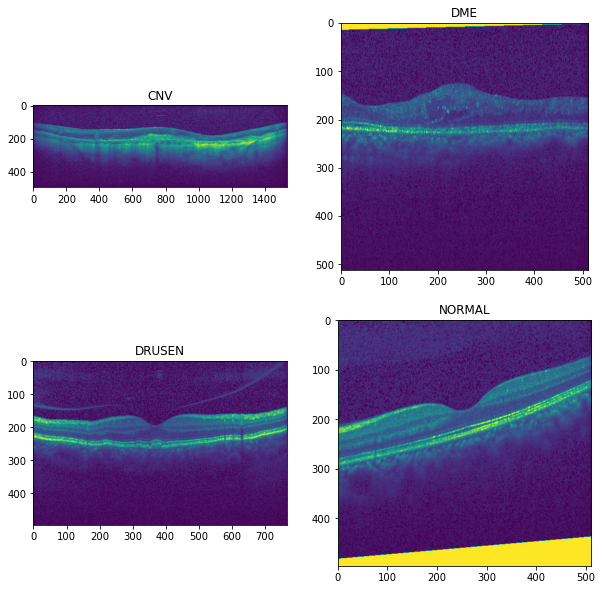

In [19]:
# Plot a random selection of one image from each of the four image types.

fig, axes = plt.subplots(2, 2, figsize= [10, 10])

for i, ax in enumerate(axes.flat):
    img = plt.imread(random.choice(train_directory_path_lists[i]))
    ax.set_title(image_types[i])
    ax.imshow(img)

## NOTES

-> Based on what I've seen from displaying the images we will need to:

    -> Normalize
    
    -> Re-scale (some images contain more pixels than others, this appears to be randomly distributed)
    
    -> Remove yellow cutoffs on the original eye images?
    

In [20]:
def scale_and_normalize(arr):
    """
    Perform Positive Global Standardization on input array and return it.
    Arguments:
        arr: 2-dimensional image array containing int or float values
    Returns:
        arr: positive globally standardized arr of float values
    """
    arr = arr.astype('float32')
    mean, stand_dev = arr.mean(), arr.std()
    arr = (arr-mean)/stand_dev
    arr = np.clip(arr, -1, 1)
    arr = (arr+1)/2
    return arr

In [27]:
# Load images with their respective labels into arrays for training
# Standardize size of all images into 'resized_image_dimension' size (originally (512, 512)),
# convert r4esultant images to grayscale to eliminate RGB color channels, and perform 
# positive global standardization on each of the image arrays. 

X = []
y = []

for i, directory in enumerate(train_directory_path_lists):
    start_time = time.time()
    # Only read one in every one hundred files due to memory constraints
    for j, filepath in enumerate(directory):
        if j % 100 == 0:
            image = cv2.imread(filepath)
            image = cv2.resize(image, resized_image_dimension)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = scale_and_normalize(image)
            X.append(image)
            y.append(i)
    print("Time taken to process " + image_types[i] + " directory :\n\t--- %s seconds ---\n"
          %(time.time() - start_time))

X = np.array(X)
y = np.array(y)

print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Time taken to process CNV directory :
	--- 1.587223768234253 seconds ---

Time taken to process DME directory :
	--- 0.5598709583282471 seconds ---

Time taken to process DRUSEN directory :
	--- 0.484774112701416 seconds ---

Time taken to process NORMAL directory :
	--- 1.4617691040039062 seconds ---

Number of examples is: 838
X shape is: (838, 512, 512)
y shape is: (838,)


In [ ]:
# TODO
#
# Build the neural net